`ore-psych-ml-ibs-base0.ipynb` notebook (ver 2022-12-16) for the main ML analysis procedures accompanying the manuscript

### A psychological symptom based machine learning model for clinical evaluation of irritable bowel syndrome
 
by Noman Haleem, ..., Arvid Lundervold submitted to Open Research Europe.

Uses the `pq_df_pt_anon` pickle data file and runs under the following conda environment, denoted `oreibs0`:
```
conda create --name oreibs0 -c conda-forge scikit-learn python=3.8
conda activate oreibs0
conda install ipython
conda install jupyter
conda install pandas
conda install matplotlib
conda install statsmodels
conda install -c conda-forge  pingouin
conda install -c plotly plotly=5.10.0
```

In [1]:
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

import numpy as np
import pandas as pd
import statsmodels
import pingouin as pg
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import PredefinedSplit
#from pandas_profiling import ProfileReport
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

/Users/astrijlundervold/opt/anaconda3/envs/oreibs0/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
def generate_questionnaire_combinations(questionnaires):
    
    '''This function takes a dictionary as input where keys are individual
    questionnaires and values and are variables within that questionnaire.
    
    It generates and return a dictionary of all possible combinations of 
    input questionnaires. The keys in the new dictionary are questionnaire
    names separated by _ and values are combinations of all variables in those
    questionnaires.
    '''

    quest_names = questionnaires.keys()

    questionnaire_combinations = dict({})

    for l in range(0,len(questionnaires)+1):

        for subset in itertools.combinations(quest_names,l):
            if len(subset)>0:

                temp_features = [questionnaires[x] for x in subset]
                temp_features1 = []
                
                for x in temp_features:
                    for y in x:
                        temp_features1.append(y)

                questionnaire_combinations['_'.join(x for x in list(subset))] = temp_features1

    return questionnaire_combinations


In [3]:
def custom_cross_validator(train_set, folds):

    ''' CCV returns an iterable tuple of train test indices folds from given dataset based on participant group stratification
        train_set is input dataset
        folds represent the number of required folds
    '''

    iterable_indices = []

    SSS = StratifiedShuffleSplit(n_splits=folds, test_size=0.25,random_state=42)

    for train_folds,test_folds in SSS.split(train_set, train_set['stratification']):

        iterable_indices.append((train_folds,test_folds))

    return iterable_indices


In [4]:
def feature_combination_finder(questionnaire_combinations,train_set, CCV, model, model_name):

    ''' Feature combination finder takes the following inputs:
        questionnaire_combinations = A dictionary containing various combinations of questionnaires as keys and values
        train_set = training dataset
        CCV = A list of iterable train, test indices produced from participant group stratification rule 
        model = A classifier object that will be used for both feature selection and training process
        model_name = name of the classifier object to be recorded in results
        The function uses SequentialFeatureSelection technique to select n feature combinations from input questionnaire_combinations, which provide
        best performance on CCV train / test folds. 
    '''
      
    results = pd.DataFrame(columns=['Model','Questionnaire(s)','Selected Features'])
    counter = 0

    for k in questionnaire_combinations.keys():

        if 'Age' in train_set.columns and 'Gender_q' in train_set.columns:
            features = questionnaire_combinations[k]+['Age','Gender_q']
            print('Age and Gender_q are added to feature combination ',k)
        
        else:
            features = questionnaire_combinations[k]


        for num_features in range(1,len(features)+1):
            
            print('Checking for  {} features in {}'.format(num_features,k))
            
            if num_features < len(features):

                X_train = train_set[features].to_numpy()
                y_train = train_set['label'].to_numpy()

                # FS = Feature selection pipeline

                FS = Pipeline([
                    ('scaler', StandardScaler()),
                    ('SFS', SequentialFeatureSelector(estimator=model,
                                                            direction = 'backward',
                                                            n_jobs=-1,
                                                            cv=CCV,
                                                            scoring = 'balanced_accuracy', 
                                                            n_features_to_select=num_features)
                    )
                ])                                                           

                FS.fit(X_train,y_train)

                selected_features = [a for a,b in zip(features,FS['SFS'].get_support()) if b]

            else:

                selected_features = features

            results.loc[counter] = [model_name,k,selected_features]
            counter += 1

    return results


In [5]:
def rank_features(trained_model, X_train,y_train, features, method='permutation'):

    ''' A simple supplementary function which takes trained model, training data and features used in training process as inputs 
        to rank features using either permutation testing or feature importance method. The latter is allowed only if the
        underlying model support the method.
    '''

    if method == 'feature_importance':
        
        importance_df = pd.DataFrame({'importance':trained_model.feature_importances_,
                                     'features':features,
                                     'std':np.std(
                                         [a.feature_importances_ for a in trained_model.estimators_],axis=0)})
    
        title = 'Feature importances'
        
    else:

        result = permutation_importance(trained_model,X_train,y_train,n_repeats=10,
                                   random_state=42)

        importance_df = pd.DataFrame({'importance':result.importances_mean,
                                     'features':features,
                                     'std':result.importances_std})

        title = 'Permutation importances'

    importance_df = importance_df.sort_values('importance',ascending=False)

    x = importance_df['features'][:30]
    y = importance_df['importance'][:30]

    fig = go.Figure()

    fig.add_trace(go.Bar(x=x,
                    y=y,
                #  error_y=error_y,
                ))

    fig.update_layout(title = title,
                        xaxis_tickangle=-45)

    return fig, 

In [6]:
def annotated_confusion_matrix(data, labels=['HC','IBS']):

    ''' A  function to produce interactive confusion matrix using Plotly
    '''
    data = data.astype(np.float)
    data = np.flipud(data)
    data = data.astype(np.int)

    x = [labels[0],labels[1]]
    y = [labels[1],labels[0]]


    fig = ff.create_annotated_heatmap(data, 
                                        x=x, 
                                        y=y, 
                                        annotation_text=data,
                                        colorscale = 'blues',
                                        )
    
    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 18


    fig.update_layout(height = 500,
                        width = 500
                        )
    
    return fig

In [7]:
# Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [8]:
# Reading anonymized patient questionnaire dataframe from (pickle file)
#df = pd.read_pickle('data/pq_df_pt_anon') 
#  or the .csv-file
#dff = pd.read_csv('data/pq_df_pt_anon.csv')
dff = pd.read_csv('data/BG_id_train_valdid_test_TFS_Chalder.csv')
#dff.index = dff['pt_anon_ids']
df = dff.drop(['BG_id'], axis=1)
dff
df

FileNotFoundError: [Errno 2] No such file or directory: 'data/BG_id_train_valdid_test_TFS_Chalder.csv'

In [ ]:
df.head()

,Category,Sub_category,Gender,Age,BIS_Q1_BL,BIS_Q2_BL,BIS_Q3_BL,BIS_Q4_BL,BIS_Q5_BL,BIS_Q6_BL,...,HADS_q5_BL,HADS_q6_BL,HADS_q7_BL,HADS_q8_BL,HADS_q9_BL,HADS_q10_BL,HADS_q11_BL,HADS_q12_BL,HADS_q13_BL,HADS_q14_BL
pt_anon_ids,,,,,,,,,,,,,,,,,,,,,
BGA_046,IBS,Diarrhea,M,38.0,0.0,0.0,3.0,5.0,5.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0
BGA_048,IBS,Diarrhea,F,34.0,7.0,4.0,0.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BGA_051,IBS,Diarrhea,M,38.0,6.0,1.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0
BGA_058,IBS,Diarrhea,F,57.0,1.0,3.0,4.0,4.0,4.0,4.0,...,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0
BGA_068,IBS,Mixed,M,31.0,2.0,1.0,0.0,7.0,5.0,3.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


In [13]:
df.groupby('Category').count()

NameError: name 'df' is not defined

In [ ]:
# Assigning quantitative representation for gender i.e. 0 for males and 1 for females
df['Gender_q'] = df['Gender'].apply(lambda x: 0 if x=='M' else 1)

# Assiging label based participant category i.e. 0 for healthy controls and 1 for IBS patients
df['label'] = df['Category'].apply(lambda x: 0 if x=='HC' else 1)

In [9]:
df.T

NameError: name 'df' is not defined

In [10]:
df.columns

NameError: name 'df' is not defined

In [11]:
# We ignore this step - requires installation of pandas-profiling

#Report = ProfileReport(df, title= 'Patient questionnaire exploration', explorative=True)
#Report.to_notebook_iframe()

In [12]:
questionnaires = ({
                    'Anx':['HADS_q{}_BL'.format(x) for x in range(1,14,2)],
                    'Dep':['HADS_q{}_BL'.format(x) for x in range(2,15,2)],
                    'Bis':[x for x in df.columns if 'BIS' in x],
                    'Fss':[x for x in df.columns if 'FSS' in x],
                })

BFH_questionnairs = questionnaires['Bis'] + questionnaires['Fss'] + questionnaires['Anx'] + questionnaires['Dep']
nitems = len(BFH_questionnairs)
ndf = len(df)
print(f'len(df): {ndf}; total number of items: {nitems}')

NameError: name 'df' is not defined

In [16]:
# Defining variable type i.e. categorial or numerical

for col in questionnaires['Bis']:
    df[col] = df[col].astype('float64')
    
for col in questionnaires['Fss']+questionnaires['Anx']+questionnaires['Dep']+['Gender_q','label']:
    df[col] = df[col].astype('category')   

**Find  fraction of 50% of length of shortest Questionnaire and total number of items:**

In [17]:
x = min(len(y) for y in questionnaires.values()) # Questionnaire with minimum items 
p = np.round((0.5*x) / np.sum([len(y) for y in questionnaires.values()]), 2) 
print(f'Questionnarie with least number of items: min={x}, p={p}')

Questionnarie with least number of items: min=6, p=0.09


In [18]:
to_drop = []        # Dropping those participants who miss more than p % of their data

for i in df.index:
    
    missing_percent = df.loc[i].isna().sum() / df.shape[1]

    if (missing_percent > p) or (pd.isna(df['Category'].loc[i])):
        print(f"df['Category'].iloc[{i}]:", df['Category'].loc[i])
        to_drop.append(i)

df_mostly_complete = df.drop(to_drop)

print(f'\n{len(to_drop)} participants were dropped (at missing percentage p={p*100}%) - {len(df_mostly_complete)} subjects remain.')

df['Category'].iloc[BGA_048]: IBS
df['Category'].iloc[BGA_047]: IBS
df['Category'].iloc[BGA_062]: IBS
df['Category'].iloc[BGA_112]: IBS
df['Category'].iloc[BGA_050]: IBS
df['Category'].iloc[BGA_053]: HC
df['Category'].iloc[BGA_158]: IBS
df['Category'].iloc[BGA_165]: HC
df['Category'].iloc[BGA_173]: nan
df['Category'].iloc[BGA_056]: IBS
df['Category'].iloc[BGA_081]: HC
df['Category'].iloc[BGA_092]: HC
df['Category'].iloc[BGA_110]: HC
df['Category'].iloc[BGA_114]: IBS
df['Category'].iloc[BGA_116]: IBS
df['Category'].iloc[BGA_135]: IBS
df['Category'].iloc[BGA_138]: IBS
df['Category'].iloc[BGA_127]: HC
df['Category'].iloc[BGA_186]: nan

19 participants were dropped (at missing percentage p=9.0%) - 84 subjects remain.


In [19]:
df_mostly_complete

,Category,Sub_category,Gender,Age,BIS_Q1_BL,BIS_Q2_BL,BIS_Q3_BL,BIS_Q4_BL,BIS_Q5_BL,BIS_Q6_BL,...,HADS_q7_BL,HADS_q8_BL,HADS_q9_BL,HADS_q10_BL,HADS_q11_BL,HADS_q12_BL,HADS_q13_BL,HADS_q14_BL,Gender_q,label
pt_anon_ids,,,,,,,,,,,,,,,,,,,,,
BGA_046,IBS,Diarrhea,M,38.0,0.0,0.0,3.0,5.0,5.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0,1
BGA_051,IBS,Diarrhea,M,38.0,6.0,1.0,1.0,2.0,0.0,2.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0,1
BGA_058,IBS,Diarrhea,F,57.0,1.0,3.0,4.0,4.0,4.0,4.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1,1
BGA_068,IBS,Mixed,M,31.0,2.0,1.0,0.0,7.0,5.0,3.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0,1
BGA_071,IBS,Diarrhea,M,35.0,2.0,5.0,3.0,3.0,3.0,3.0,...,1.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGA_139,IBS,Mixed,F,47.0,0.0,1.0,1.0,7.0,7.0,7.0,...,0.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,1,1
BGA_141,IBS,Mixed,F,29.0,1.0,1.0,0.0,6.0,3.0,5.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1,1
BGA_082,HC,HC,F,46.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [20]:
df_mostly_complete.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84 entries, BGA_046 to BGA_126
Data columns (total 39 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Category      84 non-null     object  
 1   Sub_category  84 non-null     object  
 2   Gender        84 non-null     object  
 3   Age           84 non-null     float64 
 4   BIS_Q1_BL     84 non-null     float64 
 5   BIS_Q2_BL     84 non-null     float64 
 6   BIS_Q3_BL     84 non-null     float64 
 7   BIS_Q4_BL     84 non-null     float64 
 8   BIS_Q5_BL     84 non-null     float64 
 9   BIS_Q6_BL     84 non-null     float64 
 10  FSS_Q1_BL     84 non-null     category
 11  FSS_Q10_BL    84 non-null     category
 12  FSS_Q11_BL    82 non-null     category
 13  FSS_Q12_BL    84 non-null     category
 14  FSS_Q13_BL    84 non-null     category
 15  FSS_Q2_BL     84 non-null     category
 16  FSS_Q3_BL     84 non-null     category
 17  FSS_Q4_BL     84 non-null     category
 18  FSS_Q5

In [21]:
df_mostly_complete.shape

(84, 39)

In [22]:
# Checking completeness
df_mostly_complete.isna().sum()

Category        0
Sub_category    0
Gender          0
Age             0
BIS_Q1_BL       0
BIS_Q2_BL       0
BIS_Q3_BL       0
BIS_Q4_BL       0
BIS_Q5_BL       0
BIS_Q6_BL       0
FSS_Q1_BL       0
FSS_Q10_BL      0
FSS_Q11_BL      2
FSS_Q12_BL      0
FSS_Q13_BL      0
FSS_Q2_BL       0
FSS_Q3_BL       0
FSS_Q4_BL       0
FSS_Q5_BL       0
FSS_Q6_BL       0
FSS_Q7_BL       1
FSS_Q8_BL       0
FSS_Q9_BL       0
HADS_q1_BL      0
HADS_q2_BL      0
HADS_q3_BL      0
HADS_q4_BL      0
HADS_q5_BL      0
HADS_q6_BL      0
HADS_q7_BL      0
HADS_q8_BL      0
HADS_q9_BL      0
HADS_q10_BL     0
HADS_q11_BL     0
HADS_q12_BL     0
HADS_q13_BL     0
HADS_q14_BL     0
Gender_q        0
label           0
dtype: int64

**Data Imputation using most frequent method**

In [23]:
# Seperating HC and IBS dataframes to impute missing values with the most frequent values from each category

HC_df = df_mostly_complete[df_mostly_complete['Category'] == 'HC'] 
IBS_df = df_mostly_complete[df_mostly_complete['Category'] == 'IBS']

print('Missing data points in HC_df are', HC_df.isna().sum().sum())
print('Missing data points in IBS_df are', IBS_df.isna().sum().sum())

Missing data points in HC_df are 2
Missing data points in IBS_df are 1


In [24]:
imputer = SimpleImputer(strategy='most_frequent')

HC_df_imputed = HC_df.iloc[:,3:]
HC_df_imputed = pd.DataFrame(imputer.fit_transform(HC_df_imputed),
                                 index=HC_df_imputed.index, 
                                 columns=HC_df_imputed.columns)
HC_df_imputed = pd.concat([HC_df.iloc[:,0:3], HC_df_imputed], axis=1)

IBS_df_imputed = IBS_df.iloc[:,3:]
IBS_df_imputed = pd.DataFrame(imputer.fit_transform(IBS_df_imputed),
                                 index=IBS_df_imputed.index, 
                                 columns=IBS_df_imputed.columns)
IBS_df_imputed = pd.concat([IBS_df.iloc[:,0:3], IBS_df_imputed], axis=1)

complete_df = pd.concat([HC_df_imputed,IBS_df_imputed])

df = complete_df.copy()

**Stratifying participants based on disease sub category and gender to achieve suitable representation in training, validation and testing data (as opposed to stratification by age)**

In [25]:
# Assigning labels for stratification based on IBS subcategory 

for i in df.index:
    df.loc[i, 'stratification'] = '{}_{}'.format(df.loc[i,'Sub_category'], df.loc[i,'Gender'])


In [26]:
SSS_for_test_data = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42) # Stratified sample split for test datasets
SSS_for_valid_train_data = StratifiedShuffleSplit(n_splits=1, test_size=0.25,random_state=42) # Stratified sample split for train and validation datasets

for train_valid_index, test_index in SSS_for_test_data.split(df, df['stratification']):
    train_valid_set = df.iloc[train_valid_index]
    test_set = df.iloc[test_index]                  # Unseen / kept out dataset
    
for train_index, valid_index in SSS_for_valid_train_data.split(train_valid_set, train_valid_set['stratification']):
    train_set = train_valid_set.iloc[train_index]    # Training dataset
    valid_set = train_valid_set.iloc[valid_index]    # To be used for validation

print(' Total sample size: {} \n Samples for training: {} \n Samples for validation {} \n Samples for testing (i.e. unseen) {}'\
    .format(df.shape[0],train_set.shape[0],valid_set.shape[0],test_set.shape[0]))

 Total sample size: 84 
 Samples for training: 50 
 Samples for validation 17 
 Samples for testing (i.e. unseen) 17


### Save anonymized train, validation and test datasets to .csv files

In [27]:
df_train = train_set.drop(columns= ['label', 'Gender_q'])
df_train.shape

(50, 38)

In [28]:
df_valid = valid_set.drop(columns= ['label', 'Gender_q'])
df_valid.shape

(17, 38)

In [29]:
df_test = test_set.drop(columns= ['label', 'Gender_q'])
df_test.shape

(17, 38)

In [30]:
df_train.to_csv('data/training.csv')
df_valid.to_csv('data/validation.csv')
df_test.to_csv('data/testing.csv')

### Key characteristics of the participants included in the study (Table 1)

In [31]:
# Stack the DataFrames on top of each other
df_all = pd.concat([df_train, df_valid, df_test], axis=0)
df_all.to_csv('data/train_valid_test.csv')
df_all.T

pt_anon_ids,BGA_149,BGA_151,BGA_060,BGA_085,BGA_046,BGA_152,BGA_059,BGA_122,BGA_139,BGA_071,...,BGA_161,BGA_142,BGA_130,BGA_147,BGA_074,BGA_076,BGA_115,BGA_094,BGA_088,BGA_065
Category,IBS,IBS,IBS,IBS,IBS,IBS,IBS,IBS,IBS,IBS,...,IBS,IBS,HC,IBS,IBS,HC,IBS,IBS,HC,HC
Sub_category,Mixed,Diarrhea,Mixed,Mixed,Diarrhea,Mixed,Constipation,Mixed,Mixed,Diarrhea,...,Mixed,Diarrhea,HC,Diarrhea,Constipation,HC,Diarrhea,Mixed,HC,HC
Gender,F,F,F,F,M,M,F,F,F,M,...,F,M,M,F,F,F,F,F,M,F
Age,38.0,22.0,41.0,23.0,38.0,32.0,43.0,43.0,47.0,35.0,...,21.0,46.0,38.0,61.0,48.0,24.0,58.0,27.0,33.0,23.0
BIS_Q1_BL,1.0,1.0,3.0,3.0,0.0,1.0,2.0,1.0,0.0,2.0,...,0.0,2.0,4.0,4.0,6.0,1.0,2.0,6.0,2.0,7.0
BIS_Q2_BL,0.0,0.0,2.0,0.0,0.0,1.0,3.0,4.0,1.0,5.0,...,0.0,3.0,6.0,3.0,1.0,0.0,1.0,4.0,0.0,1.0
BIS_Q3_BL,0.0,0.0,0.0,4.0,3.0,1.0,2.0,4.0,1.0,3.0,...,0.0,0.0,6.0,2.0,1.0,1.0,2.0,1.0,0.0,3.0
BIS_Q4_BL,5.0,2.0,3.0,6.0,5.0,2.0,2.0,5.0,7.0,3.0,...,3.0,5.0,3.0,3.0,1.0,2.0,5.0,7.0,4.0,4.0
BIS_Q5_BL,4.0,1.0,3.0,3.0,5.0,1.0,2.0,5.0,7.0,3.0,...,0.0,0.0,1.0,1.0,6.0,2.0,3.0,6.0,1.0,1.0
BIS_Q6_BL,1.0,2.0,4.0,7.0,3.0,1.0,2.0,6.0,7.0,3.0,...,0.0,4.0,4.0,3.0,6.0,1.0,3.0,6.0,2.0,5.0


In [32]:
df_all.groupby(['Category']).count()

,Sub_category,Gender,Age,BIS_Q1_BL,BIS_Q2_BL,BIS_Q3_BL,BIS_Q4_BL,BIS_Q5_BL,BIS_Q6_BL,FSS_Q1_BL,...,HADS_q6_BL,HADS_q7_BL,HADS_q8_BL,HADS_q9_BL,HADS_q10_BL,HADS_q11_BL,HADS_q12_BL,HADS_q13_BL,HADS_q14_BL,stratification
Category,,,,,,,,,,,,,,,,,,,,,
HC,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
IBS,49,49,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49


In [33]:
# Cf. Table 1 in the ORE paper
df_all[['Category', 'Gender', 'Age']].groupby(['Category', 'Gender']).describe().round(2)

Age                                             
                count   mean    std   min   25%   50%    75%   max
Category Gender                                                   
HC       F       24.0  35.67  13.38  19.0  23.0  34.5  47.00  58.0
         M       11.0  36.36  11.54  21.0  27.5  38.0  43.50  58.0
IBS      F       38.0  36.45  11.96  19.0  27.0  35.5  42.75  61.0
         M       11.0  36.45   6.53  28.0  31.5  35.0  40.50  47.0

In [34]:
# Cf. Table 1 in the ORE paper
df_all.groupby(['Category']).Age.describe().round(2)

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
HC,35.0,35.89,12.66,19.0,23.0,36.0,46.5,58.0
IBS,49.0,36.45,10.91,19.0,28.0,35.0,43.0,61.0


**... or, more explicit**

In [35]:
df_all_IBS = df_all[df_all['Category']=='IBS']
df_all_HC = df_all[df_all['Category']=='HC']

In [36]:
l_1 = f"Variable                  IBS            HC             p-value"  

## Category

In [37]:
l_2 = f"Participant count (%) \t  \
{df_all_IBS['Category'].count()}({np.round(df_all_IBS['Category'].count()*100/df_all['Category'].count(), 2)}) \t \
{df_all_HC['Category'].count()}({np.round(df_all_HC['Category'].count()*100/df_all['Category'].count(), 2)})"

## Gender

In [38]:
l_3 = f"Males             (%) \t  \
{df_all_IBS[df_all_IBS['Gender']=='M'].Category.count()}({np.round(df_all_IBS[df_all_IBS['Gender']=='M'].Category.count()*100/df_all[df_all['Gender']=='M'].Category.count(), 2)}) \t \
{df_all_HC[df_all_HC['Gender']=='M'].Category.count()}({np.round(df_all_HC[df_all_HC['Gender']=='M'].Category.count()*100/df_all[df_all['Gender']=='M'].Category.count(), 2)})"

In [39]:
l_4 = f"Females           (%) \t  \
{df_all_IBS[df_all_IBS['Gender']=='F'].Category.count()}({np.round(df_all_IBS[df_all_IBS['Gender']=='F'].Category.count()*100/df_all[df_all['Gender']=='F'].Category.count(), 2)}) \t \
{df_all_HC[df_all_HC['Gender']=='F'].Category.count()}({np.round(df_all_HC[df_all_HC['Gender']=='F'].Category.count()*100/df_all[df_all['Gender']=='F'].Category.count(), 2)})"

## Age

In [40]:
age_ibs = df_all[df_all['Category']=='IBS'].Age.values
age_hc = df_all[df_all['Category']=='HC'].Age.values

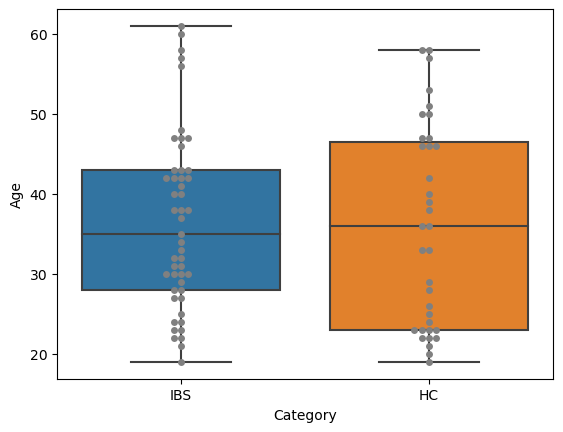

In [41]:
# Usual boxplot
ax = sns.boxplot(x='Category', y='Age', data=df_all)
# Add jitter with the swarmplot function
ax = sns.swarmplot(x='Category', y='Age', data=df_all, color="grey")
plt.show()

In [42]:
# To carry out a two-sample t-test using Pingouin we apply the ttest method:
res_age = pg.ttest(age_ibs, age_hc, correction=False)
res_age

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.218088,82,two-sided,0.827903,"[-4.57, 5.7]",0.048266,0.235,0.055339


In [43]:
from statsmodels.stats.weightstats import ttest_ind
# ttest_ind(age_ibs, age_hc))
print(f"T: {ttest_ind(age_ibs, age_hc)[0].round(6)} \t \
dof: {ttest_ind(age_ibs, age_hc)[2].astype(np.int16)} \t \
p-val: {ttest_ind(age_ibs, age_hc)[1].round(6)}")

T: 0.218088 	 dof: 82 	 p-val: 0.827903


In [44]:
l_5 = f"Mean age [yr]     (SD) \t  \
{np.round(df_all[df_all['Category']=='IBS'].Age.mean(),2)}({np.round(df_all[df_all['Category']=='IBS'].Age.std(),2)}) \t \
{np.round(df_all[df_all['Category']=='HC'].Age.mean(),2)}({np.round(df_all[df_all['Category']=='HC'].Age.std(),2)}) \t \
{ttest_ind(age_ibs, age_hc)[1].round(3)}"

## Chalder fatigue scale

In [45]:
FSS_Chalder_cols = ['FSS_Q1_BL', 'FSS_Q2_BL','FSS_Q3_BL','FSS_Q4_BL','FSS_Q5_BL','FSS_Q6_BL','FSS_Q7_BL','FSS_Q8_BL','FSS_Q9_BL', 
'FSS_Q10_BL', 'FSS_Q11_BL', 'FSS_Q12_BL', 'FSS_Q13_BL']

In [46]:
fss_dict_no = {'Mye mer enn vanlig': 1,  # 1
               'Mer enn vanlig': 1,      # 2
               'Som vanlig': 0,          # 3
               'Mindre enn vanlig': 0,   # 4
               'Ikke mer enn vanlig':0}  # 5

fss_dict_en = {'Much more than usual': 1, 
               'More than usual': 1, 
               'No more than usual': 0,
               'Less than usual': 0,
               'Not at all':0}

# CFS_Q5 = FSS_Q12_BL
QFS_Q5_dict_en = {'Sixth months or more': 1,
                  'Between three and sixth months': 2,
                  'Less than a month': 3,
                  'Less than a week': 4,
                  'I don’t feel tired': 5}

# Binarized scores for Chadler fatigue scale
fss_dict_bin_inv = {1: 1, 
                    2: 1, 
                    3: 0,
                    4: 0,
                    5: 0}

# Inverted cores for Chadler fatigue scale
fss_dict_inv = {1: 5, 
                2: 4, 
                3: 3,
                4: 2,
                5: 1}

# Binarized scores for Chadler fatigue scale - high score is more severe
fss_dict_bin = {5: 1, 
                4: 1, 
                3: 0,
                2: 0,
                1: 0}

In [47]:
# The correct items to include in Chalder scale for binary scores should be:
FSS_qs = ['FSS_Q1_BL', 'FSS_Q2_BL', 'FSS_Q3_BL', 'FSS_Q4_BL', 'FSS_Q5_BL', 'FSS_Q6_BL', 'FSS_Q7_BL', \
'FSS_Q8_BL', 'FSS_Q9_BL', 'FSS_Q10_BL', 'FSS_Q11_BL']

In [48]:
df_all_FSS_bin = df_all.copy()

In [49]:
for c in FSS_Chalder_cols:
    df_all_FSS_bin.replace({c: fss_dict_bin}, inplace=True)

df_all[FSS_Chalder_cols].T

pt_anon_ids,BGA_149,BGA_151,BGA_060,BGA_085,BGA_046,BGA_152,BGA_059,BGA_122,BGA_139,BGA_071,...,BGA_161,BGA_142,BGA_130,BGA_147,BGA_074,BGA_076,BGA_115,BGA_094,BGA_088,BGA_065
FSS_Q1_BL,4.0,3.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,...,5.0,3.0,3.0,3.0,5.0,3.0,5.0,5.0,3.0,3.0
FSS_Q2_BL,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,4.0,4.0,...,4.0,3.0,3.0,3.0,5.0,3.0,4.0,4.0,3.0,3.0
FSS_Q3_BL,4.0,2.0,4.0,5.0,4.0,4.0,3.0,4.0,4.0,4.0,...,4.0,3.0,4.0,3.0,5.0,3.0,4.0,4.0,3.0,4.0
FSS_Q4_BL,3.0,3.0,4.0,5.0,3.0,5.0,3.0,4.0,4.0,3.0,...,5.0,3.0,4.0,4.0,4.0,3.0,4.0,5.0,3.0,3.0
FSS_Q5_BL,3.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,4.0,...,5.0,3.0,3.0,4.0,5.0,3.0,4.0,4.0,3.0,3.0
FSS_Q6_BL,3.0,1.0,4.0,3.0,1.0,4.0,3.0,3.0,3.0,4.0,...,3.0,4.0,1.0,4.0,4.0,3.0,3.0,4.0,3.0,1.0
FSS_Q7_BL,3.0,3.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,...,3.0,3.0,3.0,4.0,4.0,3.0,3.0,4.0,3.0,2.0
FSS_Q8_BL,3.0,3.0,4.0,4.0,3.0,5.0,3.0,4.0,4.0,4.0,...,4.0,3.0,3.0,3.0,4.0,3.0,4.0,5.0,3.0,3.0
FSS_Q9_BL,4.0,3.0,3.0,5.0,3.0,3.0,3.0,3.0,3.0,4.0,...,3.0,3.0,3.0,2.0,5.0,3.0,3.0,3.0,3.0,3.0
FSS_Q10_BL,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,...,4.0,4.0,4.0,4.0,5.0,3.0,4.0,3.0,3.0,3.0


In [50]:
df_all_FSS_bin[FSS_Chalder_cols].T

pt_anon_ids,BGA_149,BGA_151,BGA_060,BGA_085,BGA_046,BGA_152,BGA_059,BGA_122,BGA_139,BGA_071,...,BGA_161,BGA_142,BGA_130,BGA_147,BGA_074,BGA_076,BGA_115,BGA_094,BGA_088,BGA_065
FSS_Q1_BL,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
FSS_Q2_BL,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
FSS_Q3_BL,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
FSS_Q4_BL,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
FSS_Q5_BL,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
FSS_Q6_BL,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
FSS_Q7_BL,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
FSS_Q8_BL,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
FSS_Q9_BL,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
FSS_Q10_BL,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [51]:
# Save file with Chalder sum score beeing added
df_all_TFS_Chalder = df_all_FSS_bin.copy()
df_all_TFS_Chalder['TFS_Chalder'] =  df_all_FSS_bin[FSS_qs].sum(axis=1).values
df_all_TFS_Chalder.to_csv('data/train_valid_test_TFS_Chalder.csv')

In [52]:
df_all_FSS_bin_IBS = df_all_FSS_bin[df_all_FSS_bin['Category']=='IBS']
df_all_FSS_bin_HC = df_all_FSS_bin[df_all_FSS_bin['Category']=='HC']

print(f"Chalder fatigue scale comprises: {FSS_qs} \n")
TFS_ibs =  df_all_FSS_bin_IBS[FSS_qs].sum(axis=1).values
print(f"Total Chalder (Fatigue) score: mean across {df_all_FSS_bin_IBS['Category'].count()} IBS subjects, i.e. TFS_ibs.mean().round(2): {TFS_ibs.mean().round(2)}")
print(f"Total Chalder (Fatigue) score: SD across {df_all_FSS_bin_IBS['Category'].count()} IBS subjects, i.e. TFS_ibs.std().round(2): {TFS_ibs.std().round(2)}")

TFS_hc =  df_all_FSS_bin_HC[FSS_qs].sum(axis=1).values
print(f"Total Chalder (Fatigue) score: mean across {df_all_FSS_bin_HC['Category'].count()} HC subjects, i.e. TFS_hc.mean().round(2): {TFS_hc.mean().round(2)}")
print(f"Total Chalder (Fatigue) score: SD across {df_all_FSS_bin_HC['Category'].count()} HC subjects, i.e. TFS_hc.std().round(2): {TFS_hc.std().round(2)}")



Chalder fatigue scale comprises: ['FSS_Q1_BL', 'FSS_Q2_BL', 'FSS_Q3_BL', 'FSS_Q4_BL', 'FSS_Q5_BL', 'FSS_Q6_BL', 'FSS_Q7_BL', 'FSS_Q8_BL', 'FSS_Q9_BL', 'FSS_Q10_BL', 'FSS_Q11_BL'] 

Total Chalder (Fatigue) score: mean across 49 IBS subjects, i.e. TFS_ibs.mean().round(2): 6.37
Total Chalder (Fatigue) score: SD across 49 IBS subjects, i.e. TFS_ibs.std().round(2): 3.39
Total Chalder (Fatigue) score: mean across 35 HC subjects, i.e. TFS_hc.mean().round(2): 1.6
Total Chalder (Fatigue) score: SD across 35 HC subjects, i.e. TFS_hc.std().round(2): 2.46


In [53]:
df_all_FSS_bin[FSS_qs].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
FSS_Q1_BL,84.0,0.56,0.50,0.0,0.0,1.0,1.0,1.0
FSS_Q2_BL,84.0,0.46,0.50,0.0,0.0,0.0,1.0,1.0
FSS_Q3_BL,84.0,0.58,0.50,0.0,0.0,1.0,1.0,1.0
FSS_Q4_BL,84.0,0.46,0.50,0.0,0.0,0.0,1.0,1.0
FSS_Q5_BL,84.0,0.52,0.50,0.0,0.0,1.0,1.0,1.0
FSS_Q6_BL,84.0,0.31,0.47,0.0,0.0,0.0,1.0,1.0
FSS_Q7_BL,84.0,0.27,0.45,0.0,0.0,0.0,1.0,1.0
FSS_Q8_BL,84.0,0.39,0.49,0.0,0.0,0.0,1.0,1.0
FSS_Q9_BL,84.0,0.14,0.35,0.0,0.0,0.0,0.0,1.0
FSS_Q10_BL,84.0,0.31,0.47,0.0,0.0,0.0,1.0,1.0


In [54]:
df_all_TFS = df_all_FSS_bin.copy()
df_all_TFS['TFS'] = df_all_FSS_bin[FSS_qs].sum(axis=1).values

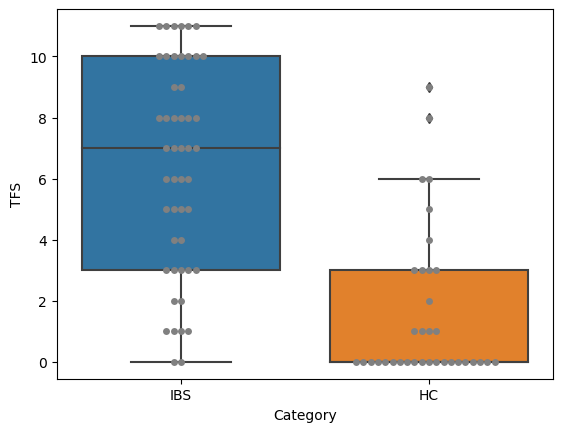

In [55]:
ax = sns.boxplot(x='Category', y='TFS', data=df_all_TFS)
# Add jitter with the swarmplot function
ax = sns.swarmplot(x='Category', y='TFS', data=df_all_TFS, color="grey")
plt.show()

In [56]:
# To carry out a two-sample t-test using Pingouin we apply the ttest method:
res_tfs = pg.ttest(TFS_ibs, TFS_hc, correction=False)
res_tfs

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.003331,82,two-sided,6.320670e-10,"[3.41, 6.12]",1.54993,1.27e+07,1.0


In [57]:
if res_tfs['p-val'].values[0] < 0.001:
    p_value_tfs = '< 0.001'
else:
    p_value_tfs = res_tfs['p-val'].values[0].round(3)
    
p_value_tfs

'< 0.001'

In [58]:
l_6 = f"TFS (Chalder 0/1) (SD) \t  \
{TFS_ibs.mean().round(2)}({TFS_ibs.std().round(2)}) \t \
{TFS_hc.mean().round(2)}({TFS_hc.std().round(2)}) \t {p_value_tfs}"

## Sleep (BIS)

In [59]:
# Bergen insomnia scale
BIS_qs = ['BIS_Q1_BL', 'BIS_Q2_BL', 'BIS_Q3_BL', 'BIS_Q4_BL', 'BIS_Q5_BL', 'BIS_Q6_BL']

print(f"Bergen insomnia sacle comprises: {BIS_qs} \n")
TSS_ibs =  df_all_IBS[BIS_qs].sum(axis=1).values
print(f"Total Sleep (Bergen insomnia) score: mean across {df_all_IBS['Category'].count()} IBS subjects, i.e. TSS_ibs.mean().round(2): {TSS_ibs.mean().round(2)}")
print(f"Total Sleep (Bergen insomnia) score: SD across {df_all_IBS['Category'].count()} IBS subjects, i.e. TSS_ibs.std().round(2): {TSS_ibs.std().round(2)}")

TSS_hc =  df_all_HC[BIS_qs].sum(axis=1).values
print(f"Total Sleep (Bergen insomnia) score: mean across {df_all_HC['Category'].count()} HC subjects, i.e. TSS_hc.mean().round(2): {TSS_hc.mean().round(2)}")
print(f"Total Sleep (Bergen insomnia) score: SD across {df_all_HC['Category'].count()} HC subjects, i.e. TSS_hc.std().round(2): {TSS_hc.std().round(2)}")


Bergen insomnia sacle comprises: ['BIS_Q1_BL', 'BIS_Q2_BL', 'BIS_Q3_BL', 'BIS_Q4_BL', 'BIS_Q5_BL', 'BIS_Q6_BL'] 

Total Sleep (Bergen insomnia) score: mean across 49 IBS subjects, i.e. TSS_ibs.mean().round(2): 16.92
Total Sleep (Bergen insomnia) score: SD across 49 IBS subjects, i.e. TSS_ibs.std().round(2): 6.78
Total Sleep (Bergen insomnia) score: mean across 35 HC subjects, i.e. TSS_hc.mean().round(2): 10.29
Total Sleep (Bergen insomnia) score: SD across 35 HC subjects, i.e. TSS_hc.std().round(2): 7.15


In [60]:
df_all_TSS = df_all.copy()
df_all_TSS['TSS'] = df_all[BIS_qs].sum(axis=1).values

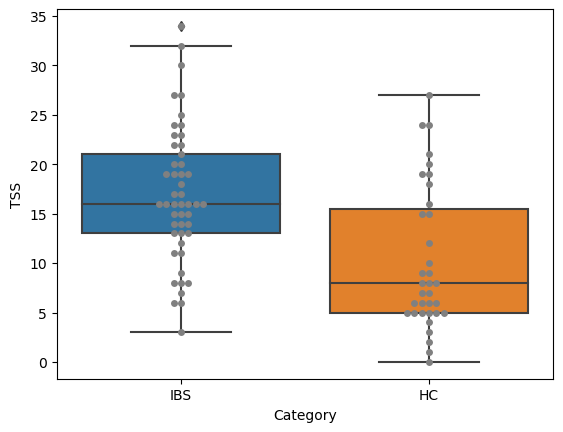

In [61]:
ax = sns.boxplot(x='Category', y='TSS', data=df_all_TSS)
# Add jitter with the swarmplot function
ax = sns.swarmplot(x='Category', y='TSS', data=df_all_TSS, color="grey")
plt.show()

In [62]:
# To carry out a two-sample t-test using Pingouin we apply the ttest method:
res_tss = pg.ttest(TSS_ibs, TSS_hc, correction=False)
res_tss

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.267143,82,two-sided,0.000053,"[3.54, 9.72]",0.944376,389.334,0.987987


In [63]:
if res_tss['p-val'].values[0] < 0.001:
    p_value_tss = '< 0.001'
else:
    p_value_tss = res_tss['p-val'].values[0].round(3)
    
p_value_tss

'< 0.001'

In [64]:
l_7 = f"TSS (BIS)         (SD) \t  \
{TSS_ibs.mean().round(2)}({TSS_ibs.std().round(2)}) \t \
{TSS_hc.mean().round(2)}({TSS_hc.std().round(2)}) \t {p_value_tss}"

## Anxiety (HADS odd)

In [65]:
ANX_qs = ['HADS_q1_BL', 'HADS_q3_BL', 'HADS_q5_BL', 'HADS_q7_BL', 'HADS_q9_BL', 'HADS_q11_BL', 'HADS_q13_BL']

In [66]:
print(f"Anxiety scale comprises: {ANX_qs} \n")
ANX_ibs =  df_all_IBS[ANX_qs].sum(axis=1).values
print(f"Total Anxiety score from HADS odd: mean across {df_all_IBS['Category'].count()} IBS subjects, i.e. ANX_ibs.mean().round(2): {ANX_ibs.mean().round(2)}")
print(f"Total Anxiety score from HADS odd: SD across {df_all_IBS['Category'].count()} IBS subjects, i.e. ANX_ibs.std().round(2): {ANX_ibs.std().round(2)}")
ANX_hc =  df_all_HC[ANX_qs].sum(axis=1).values
print(f"Total Anxiety score from HADS odd: mean across {df_all_HC['Category'].count()} HC subjects, i.e. ANX_hc.mean().round(2): {ANX_hc.mean().round(2)}")
print(f"Total Anxiety score from HADS odd: SD across {df_all_HC['Category'].count()} HC subjects, i.e. ANX_hc.std().round(2): {ANX_hc.std().round(2)}")


Anxiety scale comprises: ['HADS_q1_BL', 'HADS_q3_BL', 'HADS_q5_BL', 'HADS_q7_BL', 'HADS_q9_BL', 'HADS_q11_BL', 'HADS_q13_BL'] 

Total Anxiety score from HADS odd: mean across 49 IBS subjects, i.e. ANX_ibs.mean().round(2): 8.2
Total Anxiety score from HADS odd: SD across 49 IBS subjects, i.e. ANX_ibs.std().round(2): 4.11
Total Anxiety score from HADS odd: mean across 35 HC subjects, i.e. ANX_hc.mean().round(2): 4.09
Total Anxiety score from HADS odd: SD across 35 HC subjects, i.e. ANX_hc.std().round(2): 3.25


In [67]:
df_all_ANX = df_all.copy()
df_all_ANX['ANX'] = df_all[ANX_qs].sum(axis=1).values

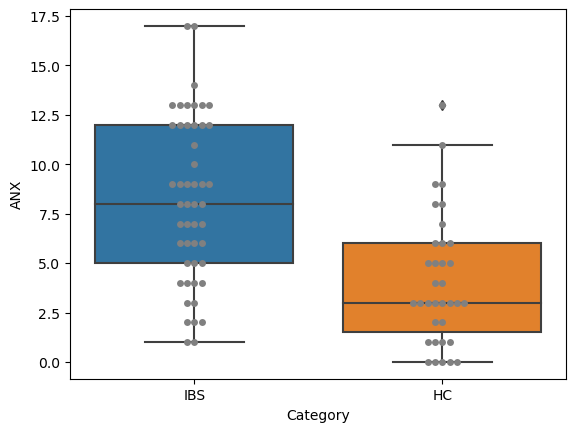

In [68]:
sns.boxplot(x='Category', y='ANX', data=df_all_ANX)
# Add jitter with the swarmplot function
ax = sns.swarmplot(x='Category', y='ANX', data=df_all_ANX, color="grey")
plt.show()

In [69]:
# To carry out a two-sample t-test using Pingouin we apply the ttest method:
res_anx = pg.ttest(ANX_ibs, ANX_hc, correction=False)
res_anx

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.871149,82,two-sided,0.000005,"[2.44, 5.8]",1.07805,3021.433,0.997837


In [70]:
if res_anx['p-val'].values[0] < 0.001:
    p_value_anx = '< 0.001'
else:
    p_value_anx = res_anx['p-val'].values[0].round(3)
    
p_value_anx

'< 0.001'

In [71]:
l_8 = f"TSS (HADS odd)    (SD) \t  \
{ANX_ibs.mean().round(2)}({ANX_ibs.std().round(2)}) \t \
{ANX_hc.mean().round(2)}({ANX_hc.std().round(2)}) \t {p_value_anx}"


## Depression (HADS even)

In [72]:
DEP_qs = ['HADS_q2_BL', 'HADS_q4_BL', 'HADS_q6_BL', 'HADS_q8_BL', 'HADS_q10_BL', 'HADS_q12_BL', 'HADS_q14_BL']

In [73]:
print(f"Depression scale comprises: {DEP_qs} \n")
DEP_ibs =  df_all_IBS[DEP_qs].sum(axis=1).values
print(f"Total Depression score from HADS even: mean across {df_all_IBS['Category'].count()} IBS subjects, i.e. DEP_ibs.mean().round(2): {DEP_ibs.mean().round(2)}")
print(f"Total Depression score from HADS even: SD across {df_all_IBS['Category'].count()} IBS subjects, i.e. DEP_ibs.std().round(2): {DEP_ibs.std().round(2)}")
DEP_hc =  df_all_HC[DEP_qs].sum(axis=1).values
print(f"Total Depression score from HADS even: mean across {df_all_HC['Category'].count()} HC subjects, i.e. DEP_hc.mean().round(2): {DEP_hc.mean().round(2)}")
print(f"Total Depression score from HADS even: SD across {df_all_HC['Category'].count()} HC subjects, i.e. DEP_hc.std().round(2): {DEP_hc.std().round(2)}")


Depression scale comprises: ['HADS_q2_BL', 'HADS_q4_BL', 'HADS_q6_BL', 'HADS_q8_BL', 'HADS_q10_BL', 'HADS_q12_BL', 'HADS_q14_BL'] 

Total Depression score from HADS even: mean across 49 IBS subjects, i.e. DEP_ibs.mean().round(2): 4.9
Total Depression score from HADS even: SD across 49 IBS subjects, i.e. DEP_ibs.std().round(2): 3.09
Total Depression score from HADS even: mean across 35 HC subjects, i.e. DEP_hc.mean().round(2): 2.09
Total Depression score from HADS even: SD across 35 HC subjects, i.e. DEP_hc.std().round(2): 2.3


In [74]:
df_all_DEP = df_all.copy()
df_all_DEP['DEP'] = df_all[DEP_qs].sum(axis=1).values

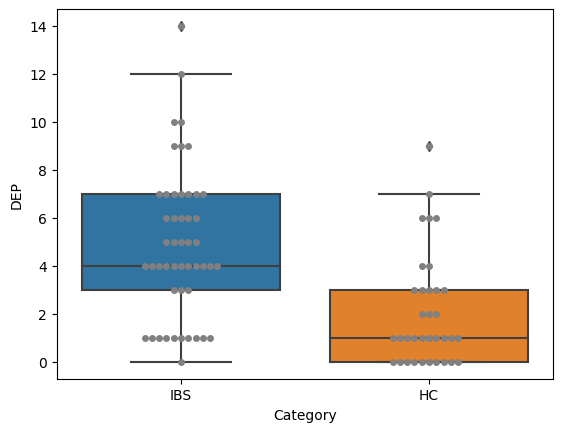

In [75]:
sns.boxplot(x='Category', y='DEP', data=df_all_DEP)
# Add jitter with the swarmplot function
ax = sns.swarmplot(x='Category', y='DEP', data=df_all_DEP, color="grey")
plt.show()

In [76]:
# To carry out a two-sample t-test using Pingouin we apply the ttest method:
res_dep = pg.ttest(DEP_ibs, DEP_hc, correction=False)
res_dep

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.502135,82,two-sided,0.000022,"[1.57, 4.05]",0.996383,845.684,0.993592


In [77]:
if res_dep['p-val'].values[0] < 0.001:
    p_value_dep = '< 0.001'
else:
    p_value_dep = res_dep['p-val'].values[0].round(3)
    
p_value_dep

'< 0.001'

In [78]:
l_9 = f"TDS (HADS even)   (SD) \t  \
{DEP_ibs.mean().round(2)}({DEP_ibs.std().round(2)}) \t \
{DEP_hc.mean().round(2)}({DEP_hc.std().round(2)}) \t {p_value_anx}"


 ## Finally, print the content of Table 1

In [79]:
print(f"Table 1: Key characteristics of the participants included in the study (n={df_all.Category.count()})\n")
for i in range(9):
    cmd = f"print(l_{i+1})"
    eval(cmd)

Table 1: Key characteristics of the participants included in the study (n=84)

Variable                  IBS            HC             p-value
Participant count (%) 	  49(58.33) 	 35(41.67)
Males             (%) 	  11(50.0) 	 11(50.0)
Females           (%) 	  38(61.29) 	 24(38.71)
Mean age [yr]     (SD) 	  36.45(10.91) 	 35.89(12.66) 	 0.828
TFS (Chalder 0/1) (SD) 	  6.37(3.39) 	 1.6(2.46) 	 < 0.001
TSS (BIS)         (SD) 	  16.92(6.78) 	 10.29(7.15) 	 < 0.001
TSS (HADS odd)    (SD) 	  8.2(4.11) 	 4.09(3.25) 	 < 0.001
TDS (HADS even)   (SD) 	  4.9(3.09) 	 2.09(2.3) 	 < 0.001


**Some more info and checking**

In [80]:
train_set.groupby(['stratification']).count()

,Category,Sub_category,Gender,Age,BIS_Q1_BL,BIS_Q2_BL,BIS_Q3_BL,BIS_Q4_BL,BIS_Q5_BL,BIS_Q6_BL,...,HADS_q7_BL,HADS_q8_BL,HADS_q9_BL,HADS_q10_BL,HADS_q11_BL,HADS_q12_BL,HADS_q13_BL,HADS_q14_BL,Gender_q,label
stratification,,,,,,,,,,,,,,,,,,,,,
Constipation_F,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Diarrhea_F,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
Diarrhea_M,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
HC_F,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
HC_M,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
Mixed_F,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
Mixed_M,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [81]:
valid_set.groupby(['stratification']).count()

,Category,Sub_category,Gender,Age,BIS_Q1_BL,BIS_Q2_BL,BIS_Q3_BL,BIS_Q4_BL,BIS_Q5_BL,BIS_Q6_BL,...,HADS_q7_BL,HADS_q8_BL,HADS_q9_BL,HADS_q10_BL,HADS_q11_BL,HADS_q12_BL,HADS_q13_BL,HADS_q14_BL,Gender_q,label
stratification,,,,,,,,,,,,,,,,,,,,,
Constipation_F,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Diarrhea_F,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Diarrhea_M,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HC_F,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
HC_M,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Mixed_F,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Mixed_M,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [82]:
test_set.groupby(['stratification']).count()

,Category,Sub_category,Gender,Age,BIS_Q1_BL,BIS_Q2_BL,BIS_Q3_BL,BIS_Q4_BL,BIS_Q5_BL,BIS_Q6_BL,...,HADS_q7_BL,HADS_q8_BL,HADS_q9_BL,HADS_q10_BL,HADS_q11_BL,HADS_q12_BL,HADS_q13_BL,HADS_q14_BL,Gender_q,label
stratification,,,,,,,,,,,,,,,,,,,,,
Constipation_F,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Diarrhea_F,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Diarrhea_M,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
HC_F,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
HC_M,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Mixed_F,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
Mixed_M,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


## Generating all possible combinations of four questionnaires

In [83]:
questionnaire_combinations = generate_questionnaire_combinations(questionnaires)
list(questionnaire_combinations.keys())

['Anx',
 'Dep',
 'Bis',
 'Fss',
 'Anx_Dep',
 'Anx_Bis',
 'Anx_Fss',
 'Dep_Bis',
 'Dep_Fss',
 'Bis_Fss',
 'Anx_Dep_Bis',
 'Anx_Dep_Fss',
 'Anx_Bis_Fss',
 'Dep_Bis_Fss',
 'Anx_Dep_Bis_Fss']

#### Generating ten folds of train_set in accordance with participant stratification

In [84]:
# Generating ten folds of train_set in accordance with participant stratification (as opposed to 4 folds in the previous version of the same analysis)

train_set_stratified_folds = custom_cross_validator(train_set, 10)

for x in train_set_stratified_folds:
    print(x,'\n') 

(array([ 6,  8, 48, 45, 10, 25, 41, 11, 29, 47, 26,  1, 37, 22, 39,  2,  3,
       24, 20, 31,  7,  9, 28, 43, 14, 38, 15, 17, 44,  5, 36, 30, 46, 12,
       13, 16,  4]), array([35, 42, 27, 34, 40, 18,  0, 19, 49, 21, 32, 33, 23])) 

(array([23, 39, 40, 44, 37,  7, 42, 17, 41,  5, 11, 36, 29, 19, 26,  3, 16,
       10, 31, 28, 45, 38, 14,  4,  8, 25,  9, 22,  1, 30, 48, 33, 18, 15,
       13, 24, 20]), array([43, 35, 12, 32, 21, 34,  6,  2, 27,  0, 47, 49, 46])) 

(array([38, 24, 29,  8,  1,  9, 23, 17, 36, 41, 25, 26,  7,  4, 44, 37, 39,
       34, 20, 43, 40, 32, 28, 10, 13, 48, 18, 33, 14, 16,  6, 49, 27, 42,
       22, 45,  5]), array([19,  0, 11, 30, 21, 35,  3, 15, 12,  2, 46, 47, 31])) 

(array([14, 45, 44, 16, 31, 34, 20,  9, 24, 18, 32, 29, 25, 19, 11,  8, 13,
        4, 26, 40, 21, 33, 42, 35, 23, 38,  1, 39,  6,  7, 46,  3, 27,  2,
        5,  0, 36]), array([43, 22, 17, 48, 49, 12, 28, 47, 15, 37, 41, 30, 10])) 

(array([ 4, 48, 22,  3, 13, 14, 19, 17, 31, 34, 39, 15, 20, 

In [85]:
print("Training set 10-fold partioning:")
print(f"len(x[0]: {len(x[0])}, len(x[1]): {len(x[1])}")

Training set 10-fold partioning:
len(x[0]: 37, len(x[1]): 13


## Using Logistic regression

In [86]:
%%time
# Sequential feature selection based on train_set

model = LogisticRegression(max_iter=5000)
model_name = 'LR'

# Run sequential feature selector, which may take some time (Wall time: 8-15 min depending of HW)

#results_LR = feature_combination_finder(questionnaire_combinations, train_set,train_set_stratified_folds, model, model_name)

#results_LR.to_pickle('data/10fold_results_LR.pickle')

# or read pre-stored results from this step


CPU times: user 20 µs, sys: 1e+03 ns, total: 21 µs
Wall time: 23.1 µs


In [87]:
# or read pre-stored results from this step
results_LR = pd.read_pickle('data/10fold_results_LR.pickle')

In [88]:
results_LR

,Model,Questionnaire(s),Selected Features
0,LR,Anx,[HADS_q7_BL]
1,LR,Anx,"[HADS_q5_BL, HADS_q7_BL]"
2,LR,Anx,"[HADS_q5_BL, HADS_q7_BL, HADS_q13_BL]"
3,LR,Anx,"[HADS_q5_BL, HADS_q7_BL, HADS_q13_BL, Age]"
4,LR,Anx,"[HADS_q1_BL, HADS_q5_BL, HADS_q7_BL, HADS_q13_..."
...,...,...,...
289,LR,Anx_Dep_Bis_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q9_B..."
290,LR,Anx_Dep_Bis_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q9_B..."
291,LR,Anx_Dep_Bis_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q9_B..."
292,LR,Anx_Dep_Bis_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q7_B..."


**Deleting instances with non representative features**

###### "Some of these feature combinations were not valid representation of the participating questionnaires as they did not included any features from each of the questionnaires in the group in some instances. For example, if a feature combination was selected from ANX+DEP+FSS questionnaire group but it only contained features related to anxiety due to relatively superior discriminability of ANX related features compared to DEP and FSS, it was excluded from further analysis on grounds of non-representativeness as it represented ANX questionnaire instead of the group of ANX+DEP+FSS questionnaires." Taken from manuscript 

In [89]:
non_representative_combinations = []

for x in results_LR.index:

    temp1 = []
    temp2 = [questionnaire_combinations[y] for y in results_LR.loc[x, 'Questionnaire(s)'].split('_')]

    features = results_LR.loc[x, 'Selected Features']

    for z in temp2:

        temp1.append([a for a in z if a in features])

    if not all(temp1):

        print('{} is not representative \n Questionnaires: {} \n Features: {}'.format(x,results_LR.loc[x, 'Questionnaire(s)'], features))
    
        non_representative_combinations.append(x)

results_LR.drop(non_representative_combinations, inplace=True)

41 is not representative 
 Questionnaires: Anx_Dep 
 Features: ['HADS_q8_BL']
42 is not representative 
 Questionnaires: Anx_Dep 
 Features: ['HADS_q8_BL', 'HADS_q10_BL']
43 is not representative 
 Questionnaires: Anx_Dep 
 Features: ['HADS_q8_BL', 'HADS_q10_BL', 'HADS_q14_BL']
57 is not representative 
 Questionnaires: Anx_Bis 
 Features: ['HADS_q1_BL']
72 is not representative 
 Questionnaires: Anx_Fss 
 Features: ['FSS_Q1_BL']
73 is not representative 
 Questionnaires: Anx_Fss 
 Features: ['FSS_Q1_BL', 'FSS_Q6_BL']
94 is not representative 
 Questionnaires: Dep_Bis 
 Features: ['BIS_Q5_BL']
95 is not representative 
 Questionnaires: Dep_Bis 
 Features: ['BIS_Q1_BL', 'BIS_Q5_BL']
109 is not representative 
 Questionnaires: Dep_Fss 
 Features: ['FSS_Q3_BL']
131 is not representative 
 Questionnaires: Bis_Fss 
 Features: ['FSS_Q1_BL']
132 is not representative 
 Questionnaires: Bis_Fss 
 Features: ['FSS_Q1_BL', 'FSS_Q6_BL']
152 is not representative 
 Questionnaires: Anx_Dep_Bis 
 Feat

In [90]:
results_LR

,Model,Questionnaire(s),Selected Features
0,LR,Anx,[HADS_q7_BL]
1,LR,Anx,"[HADS_q5_BL, HADS_q7_BL]"
2,LR,Anx,"[HADS_q5_BL, HADS_q7_BL, HADS_q13_BL]"
3,LR,Anx,"[HADS_q5_BL, HADS_q7_BL, HADS_q13_BL, Age]"
4,LR,Anx,"[HADS_q1_BL, HADS_q5_BL, HADS_q7_BL, HADS_q13_..."
...,...,...,...
289,LR,Anx_Dep_Bis_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q9_B..."
290,LR,Anx_Dep_Bis_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q9_B..."
291,LR,Anx_Dep_Bis_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q9_B..."
292,LR,Anx_Dep_Bis_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q7_B..."


**Calculating balanced accuracy cross validation score during training and balanced accuracy score on validation dataset.
All operations use balanced accuracy to account for differences in number of participants in both HC and IBS classes**

In [91]:
%%time
model = LogisticRegression(max_iter=5000)

train_valid_set_stratified_folds =  custom_cross_validator(train_valid_set,10)

for x in results_LR.index:

    PL = Pipeline([
        ('Scaler', StandardScaler()),
        ('Model', model)
    ])

    features = results_LR.loc[x,'Selected Features']

    cv_score = np.mean(cross_val_score(PL, train_set[features], train_set['label'], cv= train_set_stratified_folds, scoring='balanced_accuracy'))
    results_LR.loc[x,'train cv score'] = cv_score

    PL.fit(train_set[features], train_set['label'])
    results_LR.loc[x,'validation score'] = balanced_accuracy_score(valid_set['label'], PL.predict(valid_set[features]))

CPU times: user 14.5 s, sys: 42.5 ms, total: 14.6 s
Wall time: 14.6 s


In [92]:
results_LR.sort_values(['validation score'], ascending=False)

,Model,Questionnaire(s),Selected Features,train cv score,validation score
92,LR,Anx_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q7_B...",0.72375,0.857143
80,LR,Anx_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, FSS_Q1_BL...",0.82500,0.857143
46,LR,Anx_Dep,"[HADS_q13_BL, HADS_q2_BL, HADS_q8_BL, HADS_q10...",0.80375,0.828571
50,LR,Anx_Dep,"[HADS_q1_BL, HADS_q3_BL, HADS_q13_BL, HADS_q2_...",0.76125,0.828571
292,LR,Anx_Dep_Bis_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q7_B...",0.77250,0.828571
...,...,...,...,...,...
102,LR,Dep_Bis,"[HADS_q8_BL, HADS_q10_BL, HADS_q12_BL, BIS_Q1_...",0.76500,0.564286
78,LR,Anx_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, FSS_Q1_BL...",0.83125,0.564286
103,LR,Dep_Bis,"[HADS_q4_BL, HADS_q8_BL, HADS_q10_BL, HADS_q12...",0.75875,0.564286
1,LR,Anx,"[HADS_q5_BL, HADS_q7_BL]",0.74125,0.564286


**Selecting best model in each of 16 combinations of the questionnaires based on (i) test score on validation dataset and if this test score is equal for two different models then (ii) on basis of cross validation score during training**

In [93]:
best_model_in_category_LR = pd.DataFrame([], columns=['Best features', 'validation score'])

for k in questionnaire_combinations.keys():

    questionnaire_specific_results = results_LR[(results_LR['Questionnaire(s)']==k)]
    questionnaire_specific_best_results = questionnaire_specific_results[(questionnaire_specific_results['validation score'] == questionnaire_specific_results['validation score'].max())]
    questionnaire_specific_best_results_final_model = questionnaire_specific_best_results[(questionnaire_specific_best_results['train cv score'] == questionnaire_specific_best_results['train cv score'].max())]

    best_model_in_category_LR.loc[k, 'Best features'] = questionnaire_specific_best_results_final_model.iloc[0]['Selected Features']
    best_model_in_category_LR.loc[k, 'validation score'] = questionnaire_specific_best_results_final_model.iloc[0]['validation score']


**Best models in each combination of questionnaires in terms of validation score**

In [94]:
best_model_in_category_LR

,Best features,validation score
Anx,"[HADS_q5_BL, HADS_q7_BL, HADS_q13_BL]",0.707143
Dep,[HADS_q8_BL],0.735714
Bis,"[BIS_Q2_BL, BIS_Q4_BL]",0.714286
Fss,"[FSS_Q1_BL, FSS_Q10_BL, FSS_Q11_BL, FSS_Q12_BL...",0.757143
Anx_Dep,"[HADS_q13_BL, HADS_q2_BL, HADS_q8_BL, HADS_q10...",0.828571
Anx_Bis,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q7_B...",0.807143
Anx_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, FSS_Q1_BL...",0.857143
Dep_Bis,"[HADS_q10_BL, BIS_Q1_BL, BIS_Q5_BL]",0.714286
Dep_Fss,"[HADS_q8_BL, HADS_q14_BL, FSS_Q3_BL, FSS_Q6_BL...",0.807143
Bis_Fss,"[BIS_Q3_BL, FSS_Q1_BL, FSS_Q6_BL]",0.757143


**Testing the best model in each combination of questionnaires on unseen data i.e. X_test**

In [95]:
supplementary_data_LR = pd.DataFrame([], columns= ['Classifier','X_train','y_train','X_test','y_test'])

for b in best_model_in_category_LR.index:

    final_features = best_model_in_category_LR.loc[b,'Best features']
    
    X_train = train_valid_set[final_features].to_numpy()
    y_train = train_valid_set['label'].to_numpy()
    X_test = test_set[final_features].to_numpy()
    y_test = test_set['label'].to_numpy()

    final_PL = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    final_PL.fit(X_train,y_train)

    ac = accuracy_score(y_test,final_PL.predict(X_test)) 
    bas = balanced_accuracy_score(y_test,final_PL.predict(X_test)) 
    rs = recall_score(y_test,final_PL.predict(X_test)) 
    ps = precision_score(y_test,final_PL.predict(X_test)) 
    f1s = f1_score(y_test,final_PL.predict(X_test)) 
    ras = roc_auc_score(y_test,final_PL.predict(X_test)) 

    best_model_in_category_LR.loc[b,'Accuracy score'] = ac
    best_model_in_category_LR.loc[b,'Balanced accuracy score'] = bas
    best_model_in_category_LR.loc[b,'Recall score'] = rs
    best_model_in_category_LR.loc[b,'Precision score'] = ps
    best_model_in_category_LR.loc[b,'F1 score'] = f1s
    best_model_in_category_LR.loc[b,'Roc auc score'] = ras

    supplementary_data_LR.loc[b] = [final_PL, X_train, y_train, X_test, y_test]


In [96]:
best_model_in_category_LR

,Best features,validation score,Accuracy score,Balanced accuracy score,Recall score,Precision score,F1 score,Roc auc score
Anx,"[HADS_q5_BL, HADS_q7_BL, HADS_q13_BL]",0.707143,0.823529,0.828571,0.8,0.888889,0.842105,0.828571
Dep,[HADS_q8_BL],0.735714,0.823529,0.785714,1.0,0.769231,0.869565,0.785714
Bis,"[BIS_Q2_BL, BIS_Q4_BL]",0.714286,0.705882,0.664286,0.9,0.692308,0.782609,0.664286
Fss,"[FSS_Q1_BL, FSS_Q10_BL, FSS_Q11_BL, FSS_Q12_BL...",0.757143,0.882353,0.878571,0.9,0.900000,0.900000,0.878571
Anx_Dep,"[HADS_q13_BL, HADS_q2_BL, HADS_q8_BL, HADS_q10...",0.828571,0.823529,0.828571,0.8,0.888889,0.842105,0.828571
Anx_Bis,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, HADS_q7_B...",0.807143,0.764706,0.757143,0.8,0.800000,0.800000,0.757143
Anx_Fss,"[HADS_q1_BL, HADS_q3_BL, HADS_q5_BL, FSS_Q1_BL...",0.857143,0.941176,0.928571,1.0,0.909091,0.952381,0.928571
Dep_Bis,"[HADS_q10_BL, BIS_Q1_BL, BIS_Q5_BL]",0.714286,0.647059,0.614286,0.8,0.666667,0.727273,0.614286
Dep_Fss,"[HADS_q8_BL, HADS_q14_BL, FSS_Q3_BL, FSS_Q6_BL...",0.807143,0.705882,0.707143,0.7,0.777778,0.736842,0.707143
Bis_Fss,"[BIS_Q3_BL, FSS_Q1_BL, FSS_Q6_BL]",0.757143,0.823529,0.807143,0.9,0.818182,0.857143,0.807143


**Best performance is achieved using ANX_FSS and ANX_DEP_FSS categories. We select ANX_FSS for obvious reason of minimal number of questionnaires needed**

In [97]:
best_model_in_category_LR.loc['Anx_Fss', 'Best features']

['HADS_q1_BL',
 'HADS_q3_BL',
 'HADS_q5_BL',
 'FSS_Q1_BL',
 'FSS_Q12_BL',
 'FSS_Q5_BL',
 'FSS_Q6_BL',
 'FSS_Q8_BL',
 'Gender_q']

In [98]:
# Plotting confusion matrix for the model achieved in ANX_FSS questionnaire

index = 'Anx_Fss'
features = best_model_in_category_LR.loc[index, 'Best features']
model = supplementary_data_LR.loc[index, 'Classifier']
X_train = supplementary_data_LR.loc[index, 'X_train']
y_train = supplementary_data_LR.loc[index, 'y_train']
X_test = supplementary_data_LR.loc[index, 'X_test']
y_test = supplementary_data_LR.loc[index, 'y_test']

model.fit(X_train, y_train)

cm_labels=['HC','IBS']
cm = metrics.confusion_matrix(y_test,model.predict(X_test))
#cm_fig = annotated_confusion_matrix(cm, cm_labels)
#cm_fig.show()


print('Balanced test Accuracy: {:.02f}%'.format(balanced_accuracy_score(y_test,model.predict(X_test))*100))
print('Test Accuracy: {:.02f}%'.format(model.score(X_test,y_test)*100))

Balanced test Accuracy: 92.86%
Test Accuracy: 94.12%


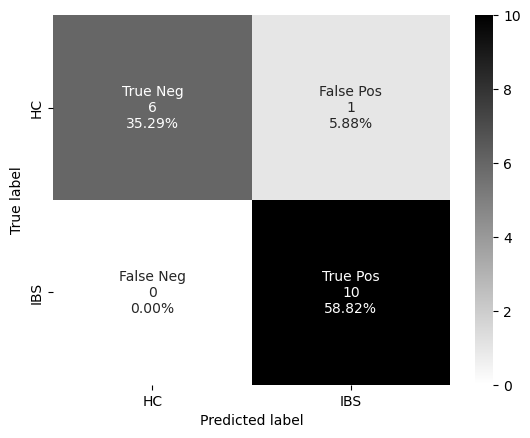

In [99]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['HC', 'IBS']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      sum_stats = False,
                      cmap='binary')